In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0-alpha0
        !pip install pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  True


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)


TFP Version 0.7.0
TF  Version 2.0.0-alpha0


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


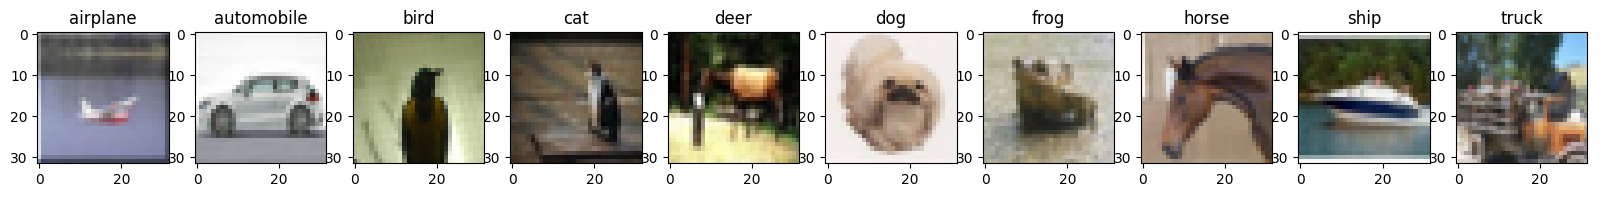

In [4]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train))):
    rmd=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=x_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(labels[i])

In [0]:
y_train_no_horse=np.delete(y_train,np.where(y_train==9)[0])
x_train_no_horse=np.delete(x_train,np.where(y_train==9)[0],axis=0)

In [6]:
print(y_train_no_horse.shape)
print(x_train_no_horse.shape)

(45000,)
(45000, 32, 32, 3)


In [0]:
y_train_no_horse = tf.keras.utils.to_categorical(y_train_no_horse)
#y_test= tf.keras.utils.to_categorical(y_test)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_no_horse, y_train_no_horse, test_size=0.4, random_state=22)


In [9]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(27000, 32, 32, 3)
(27000, 9)
(18000, 32, 32, 3)
(18000, 9)
(10000, 32, 32, 3)
(10000, 1)


In [0]:
## tf norm
x_train=((x_train/255)-0.5)*2
x_val=((x_val/255)-0.5)*2
x_test=((x_test/255)-0.5)*2

## Conv Variational

In [11]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x_train.shape[0] * 1.0)
model = tf.keras.Sequential()
model.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn,input_shape=(32,32,3)))
#model.add(tf.keras.layers.Dropout((0.3)))
model.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
#model.add(tf.keras.layers.Dropout((0.3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
#model.add(tf.keras.layers.Dropout((0.3)))
model.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
#model.add(tf.keras.layers.Dropout((0.3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
#model.add(tf.keras.layers.Dropout((0.3)))
model.add(tfp.layers.DenseFlipout(9, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 32, 32, 8)         440       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_flipout_2 (Conv2DFlip (None, 16, 16, 16)        2320      
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [12]:
for i in range(0,5):
  print(model.predict(x_train[0:1])[0])
#we get a different pred at every run!

[0.06201475 0.11049567 0.07045928 0.11920843 0.08331306 0.23143725
 0.09595498 0.17576887 0.05134778]
[0.1787479  0.16863245 0.04614203 0.0455562  0.07360359 0.15732853
 0.04302014 0.12093721 0.16603187]
[0.13659638 0.15120813 0.0694866  0.07615268 0.05919844 0.24408512
 0.0406919  0.14663135 0.07594943]
[0.10367321 0.15384842 0.04232259 0.07901891 0.06090927 0.3045087
 0.06051445 0.11384557 0.08135891]
[0.16065519 0.08627857 0.03123443 0.12419094 0.06343964 0.16566156
 0.0388895  0.15446396 0.17518617]


In [13]:
history=model.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=150,verbose=1)
# need a lot of epochs
# dropout does not help in terms of train acc and val acc
# longer training would maybe give some improvement

Train on 27000 samples, validate on 18000 samples
Epoch 1/150
27000/27000 [==============================] - 9s 333us/sample - loss: 11.7884 - accuracy: 0.2356 - val_loss: 11.2859 - val_accuracy: 0.3255
Epoch 2/150
27000/27000 [==============================] - 7s 247us/sample - loss: 10.9047 - accuracy: 0.3724 - val_loss: 10.5478 - val_accuracy: 0.4039
Epoch 3/150
27000/27000 [==============================] - 7s 244us/sample - loss: 10.2394 - accuracy: 0.4286 - val_loss: 9.9374 - val_accuracy: 0.4463
Epoch 4/150
27000/27000 [==============================] - 7s 244us/sample - loss: 9.6737 - accuracy: 0.4602 - val_loss: 9.4210 - val_accuracy: 0.4638
Epoch 5/150
27000/27000 [==============================] - 7s 245us/sample - loss: 9.1637 - accuracy: 0.4814 - val_loss: 8.9328 - val_accuracy: 0.4865
Epoch 6/150
27000/27000 [==============================] - 7s 242us/sample - loss: 8.6917 - accuracy: 0.5004 - val_loss: 8.5009 - val_accuracy: 0.4949
Epoch 7/150
27000/27000 [==============

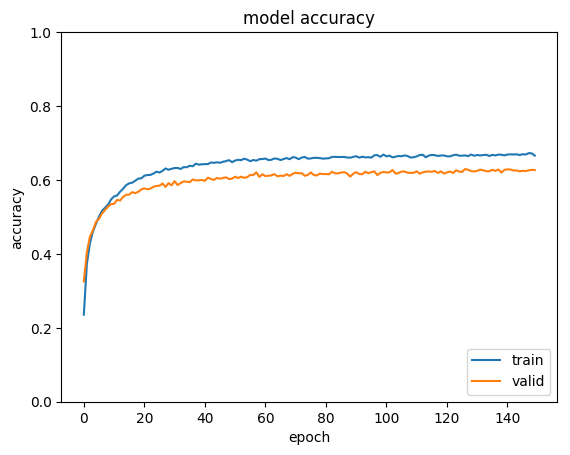

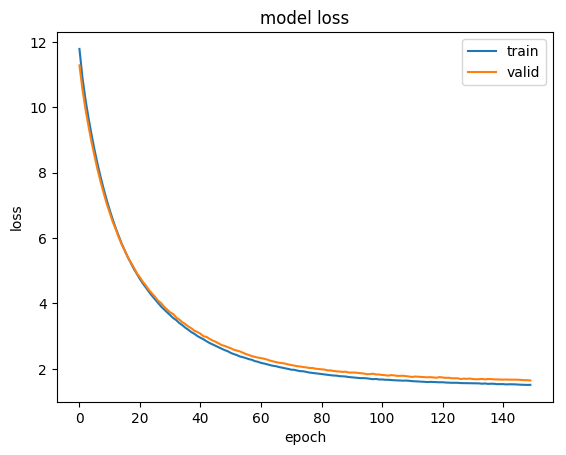

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [0]:
from tqdm import tqdm_notebook as tqdm

In [17]:
# 100 pred and then mean and argmax for the val set
SET=x_val
pred=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(20,1,1,1))
  preds=model.predict(multi_img)
  pred[i]=np.argmax(np.mean(preds,axis=0))

In [18]:
print("val_acc =" ,np.sum(pred.reshape((len(pred)))==np.argmax(y_val,axis=1))/len(SET))
#better acc than it seems when you look at val acc from the fit output (around 62%)

val_acc = 0.6896111111111111


In [19]:
max(y_test) 

array([9])

In [20]:
# 100 pred and then mean and argmax for the test set
SET=x_test
pred=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(20,1,1,1))
  preds=model.predict(multi_img)
  pred[i]=np.argmax(np.mean(preds,axis=0))
#kann maximal 90% sein  

In [35]:
np.sum(y_test==9)
len(y_test)

10000

In [32]:
print("test_acc =" ,np.sum(pred.reshape((len(pred)))==y_test.reshape((len(pred))))/len(SET))

test_acc = 0.618


array([  11,   14,   23,   28,   34,   38,   45,   47,   50,   76,   89,
        133,  136,  139,  151,  157,  170,  171,  172,  174,  175,  209,
        213,  217,  222,  225,  243,  247,  252,  253,  259,  280,  285,
        289,  293,  331,  335,  349,  350,  360,  364,  372,  381,  383,
        394,  400,  411,  415,  425,  442,  443,  451,  454,  485,  486,
        487,  504,  507,  508,  517,  530,  532,  538,  545,  554,  566,
        568,  577,  585,  589,  591,  609,  611,  625,  626,  644,  651,
        654,  660,  666,  680,  684,  686,  707,  719,  733,  734,  744,
        750,  752,  780,  787,  816,  838,  851,  853,  884,  921,  922,
        923,  938,  940,  951,  960,  967,  969,  970,  979,  981, 1008,
       1060, 1064, 1066, 1068, 1082, 1104, 1106, 1114, 1136, 1155, 1171,
       1175, 1177, 1199, 1220, 1221, 1222, 1231, 1256, 1261, 1265, 1282,
       1285, 1287, 1291, 1298, 1305, 1314, 1317, 1344, 1357, 1359, 1361,
       1370, 1376, 1384, 1387, 1406, 1417, 1424, 14

In [53]:
# 100 pred and then mean and argmax for the test set
SET=x_test[np.where(y_test==9)[0]]

pred=np.zeros((len(SET),1))
pred_std=np.zeros((len(SET),1))
pred_means=np.zeros((len(SET),9))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(20,1,1,1))
  preds=model.predict(multi_img)
  pred_means[i]= np.mean(preds,axis=0)
  pred[i]=np.argmax(np.mean(preds,axis=0))
  pred_std[i]= np.sqrt(np.sum(np.var(preds, axis=0)))

#kann maximal 90% sein  
print("acc_unknown =" ,np.sum(pred.reshape((len(pred)))==y_test[np.where(y_test==9)[0]].reshape((len(pred))))/len(SET))

acc_unknown = 0.0


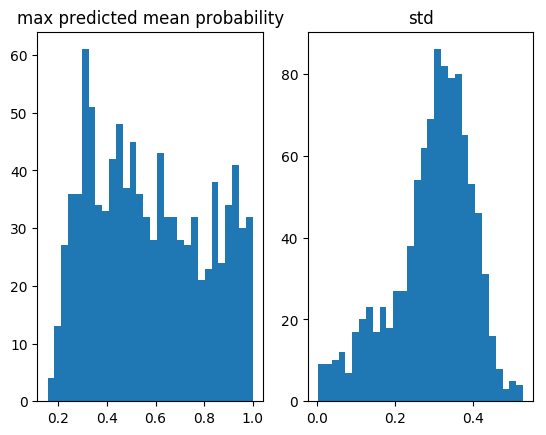

In [55]:
plt.subplot(1,2,1)
plt.hist(np.max(pred_means,axis=1),bins=30)
plt.title("max predicted mean probability")
plt.subplot(1,2,2)
plt.hist(pred_std,bins=30)
plt.title("std")
plt.show()

In [56]:
# 100 pred and then mean and argmax for the test set
SET=x_test[np.where(y_test!=9)[0]]
pred=np.zeros((len(SET),1))
pred_std=np.zeros((len(SET),1))
pred_means=np.zeros((len(SET),9))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(20,1,1,1))
  preds=model.predict(multi_img)
  pred_means[i]= np.mean(preds,axis=0)
  pred[i]=np.argmax(np.mean(preds,axis=0))
  pred_std[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
#kann maximal 90% sein  
print("acc_known =" ,np.sum(pred.reshape((len(pred)))==y_test[np.where(y_test!=9)[0]].reshape((len(pred))))/len(SET))

acc_known = 0.6883333333333334


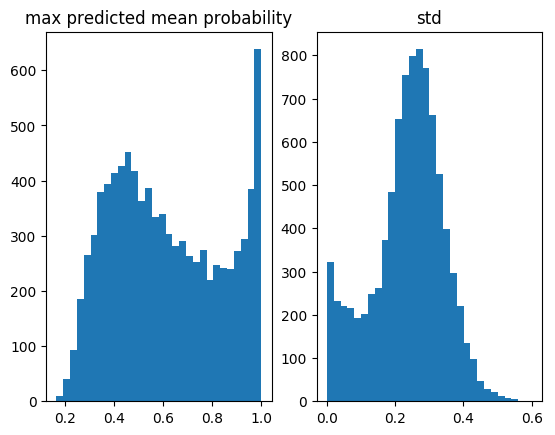

In [57]:
plt.subplot(1,2,1)
plt.hist(np.max(pred_means,axis=1),bins=30)
plt.title("max predicted mean probability")
plt.subplot(1,2,2)
plt.hist(pred_std,bins=30)
plt.title("std")
plt.show()